In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import matplotlib as mpl

# Define custom params for plots
rcParams = {
    'font.size': 20,                # all font sizes in plot
    'font.weight': 'bold',          # bold all fonts
    'figure.titleweight': 'bold',   # bold supertitle
    'axes.labelweight': 'bold',     # bold x and y labels
    'axes.linewidth': 3,            # linewidth for axes
    'xtick.major.width': 3,         # width for major ticks on x-axis
    'ytick.major.width': 3,         # width for major ticks on y-axis
    'axes.spines.top': True,
    'axes.spines.right': True,
    'lines.linewidth': 3,
    'legend.fontsize': 'large',
    'xtick.labelsize': 20,          # sets x-tick font size
    'ytick.labelsize': 20,          # sets y-tick font size
    'axes.titlepad': 20,            # spacing between title and figure
    'axes.facecolor': 'white',      # background color for axes
    'axes.titlesize': 20,           # title font size for axes
    'axes.titleweight': 'bold'      
}

# Update rcparams
mpl.rcParams.update(rcParams) 


ANOVA Results:
F-statistic: 5.9808
P-value: 0.0000

Post-hoc Analysis vs CCCV:

CCCV vs ALGO1:
Mean difference: 3.77 minutes
95% CI: [2.31, 5.23]
P-value (Bonferroni): 0.0003
Effect size (Cohen's d): 1.61

CCCV vs ALGO2:
Mean difference: 1.96 minutes
95% CI: [0.49, 3.44]
P-value (Bonferroni): 0.5761
Effect size (Cohen's d): 0.83

CCCV vs ALGO3:
Mean difference: -0.87 minutes
95% CI: [-2.09, 0.35]
P-value (Bonferroni): 1.0000
Effect size (Cohen's d): -0.44

CCCV vs ALGO4:
Mean difference: 2.30 minutes
95% CI: [0.94, 3.66]
P-value (Bonferroni): 0.0821
Effect size (Cohen's d): 1.05

CCCV vs ALGO5:
Mean difference: 0.85 minutes
95% CI: [-0.43, 2.12]
P-value (Bonferroni): 1.0000
Effect size (Cohen's d): 0.42

CCCV vs ALGO6:
Mean difference: 2.16 minutes
95% CI: [0.95, 3.36]
P-value (Bonferroni): 0.0451
Effect size (Cohen's d): 1.12

CCCV vs ALGO7:
Mean difference: 1.70 minutes
95% CI: [0.38, 3.02]
P-value (Bonferroni): 0.7039
Effect size (Cohen's d): 0.80

CCCV vs ALGO8:
Mean difference: 2

C:\Users\anita\AppData\Local\Temp\ipykernel_11800\2554698252.py:161: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


<module 'matplotlib.pyplot' from 'c:\\Users\\anita\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

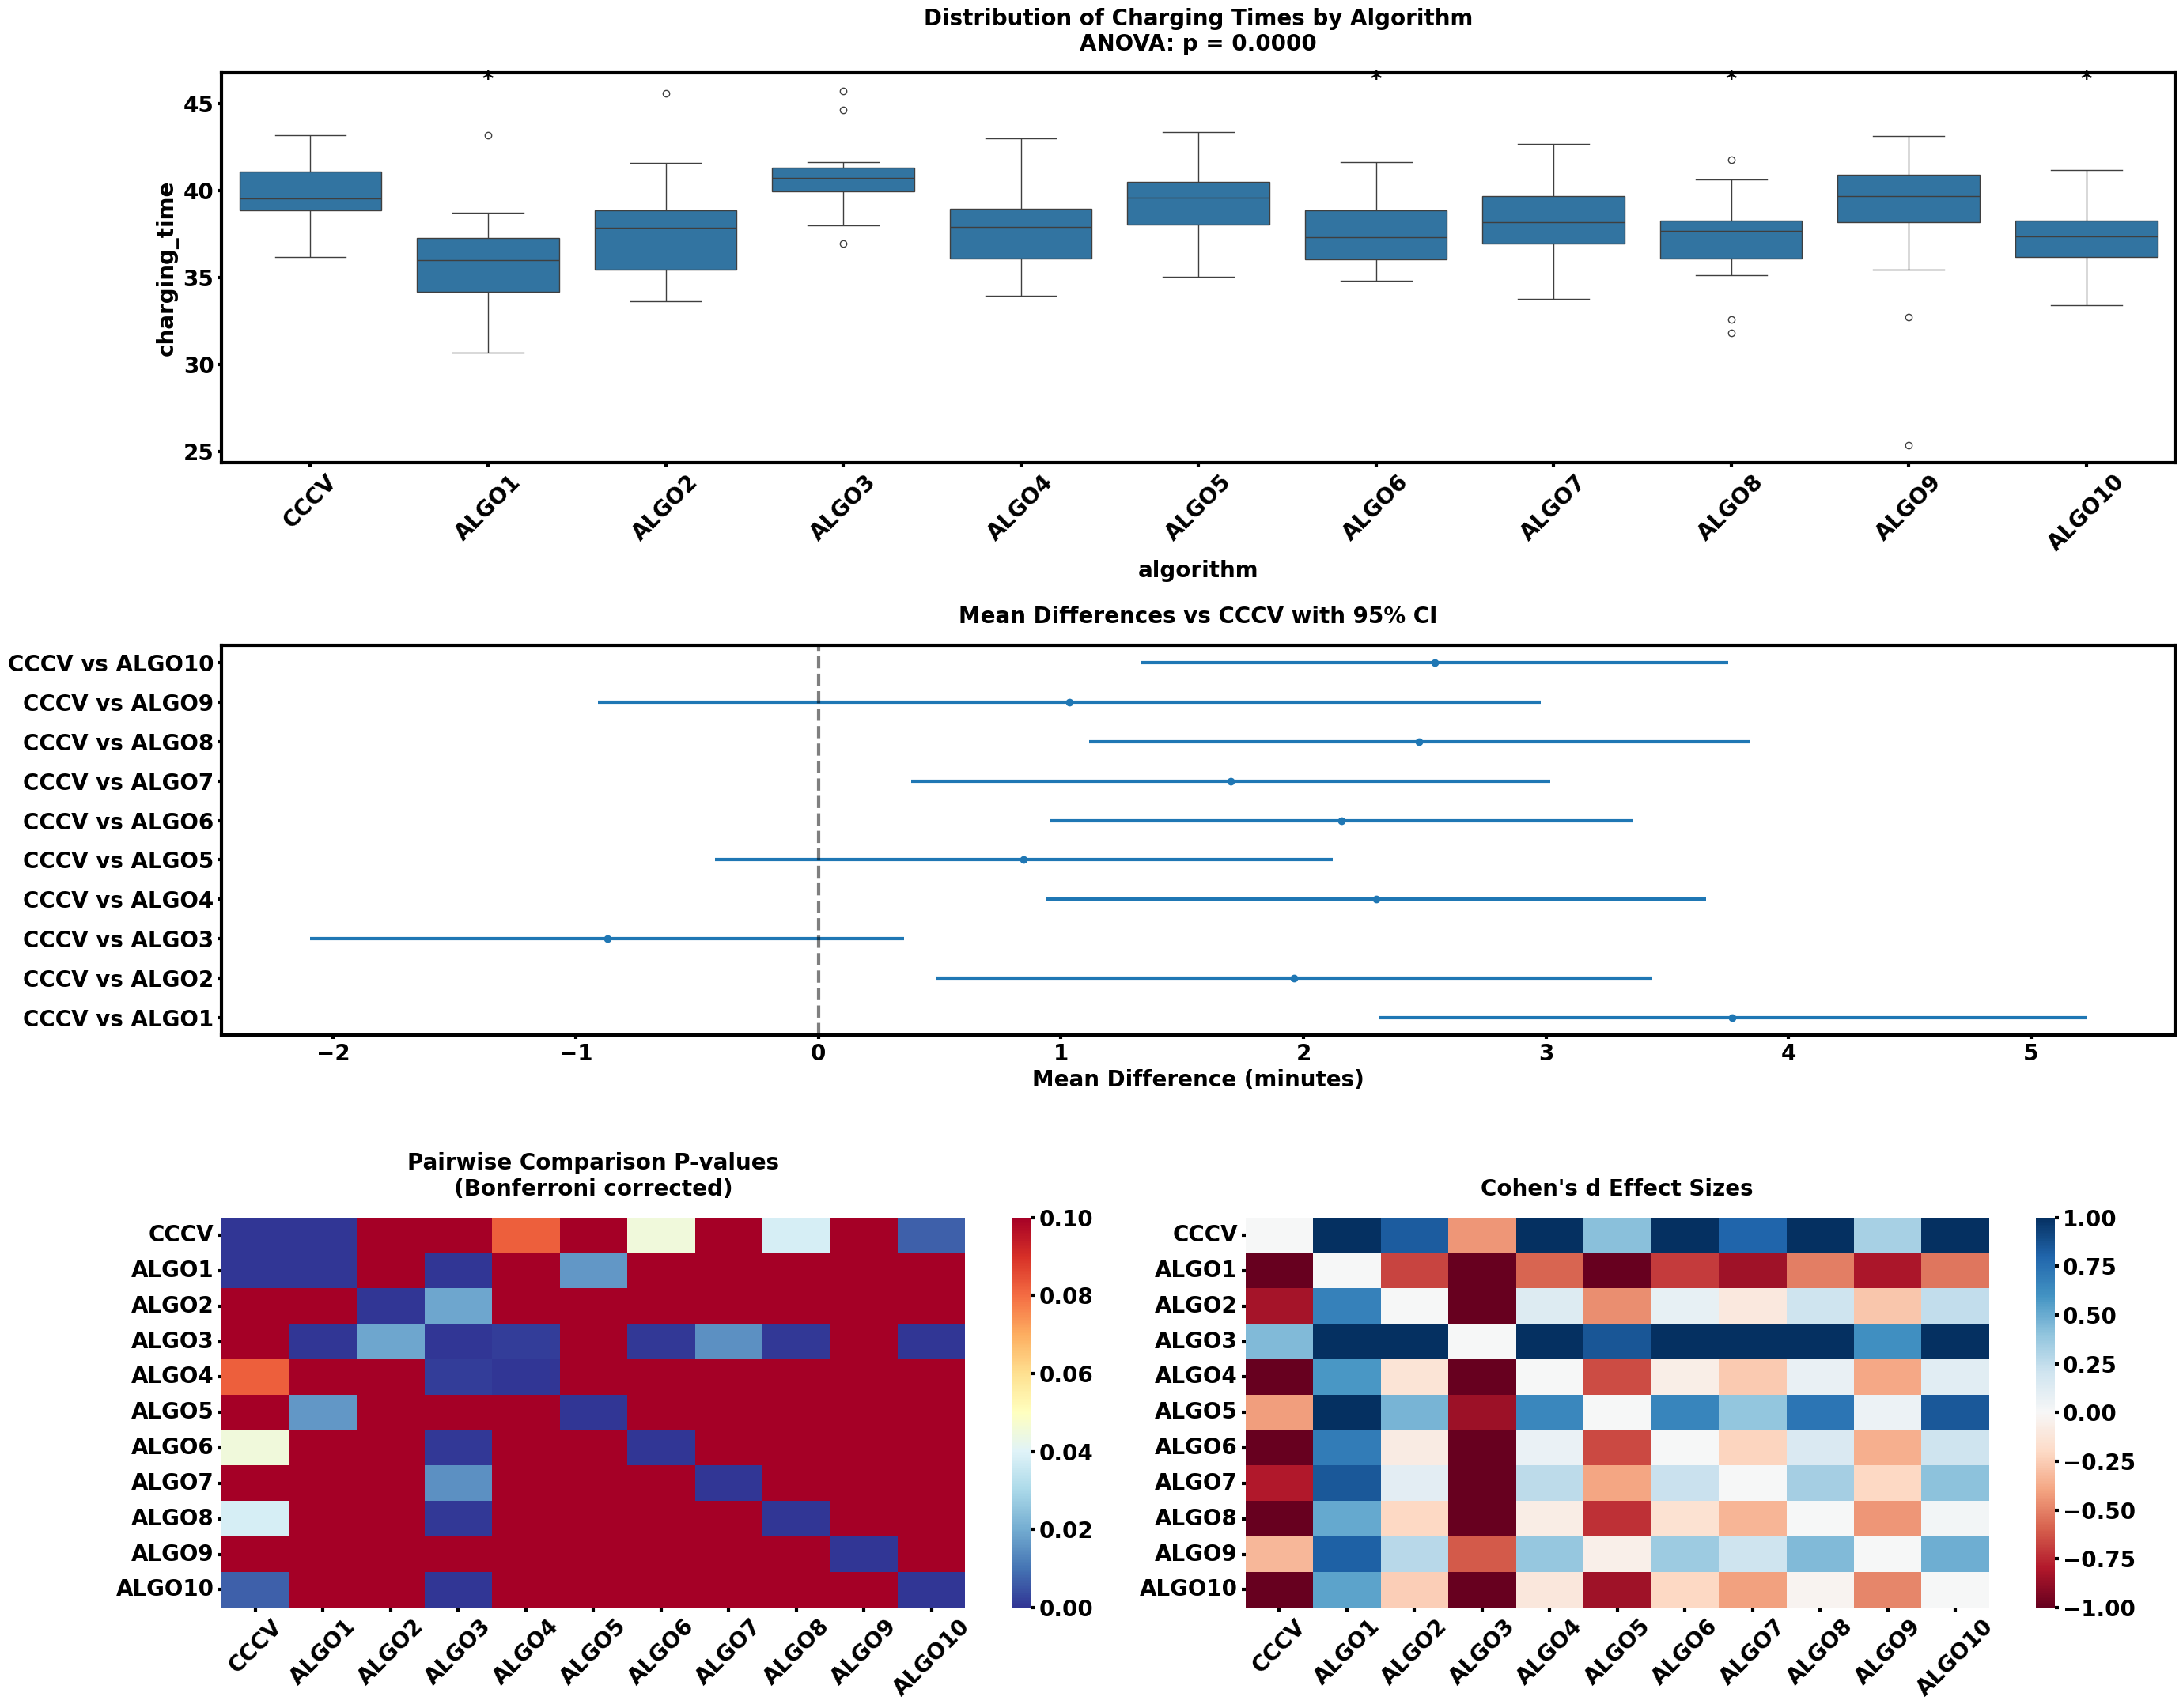

In [5]:
class BatteryTestingFramework:
    def __init__(self, 
                 base_charging_time: float = 40.0,
                 variation_percentage: float = 0.05,  # 5% variation
                 n_batteries: int = 21,              # from previous calculation
                 random_seed: int = 42):
        """
        Initialize the battery testing framework with higher variation
        and smaller, inconsistent effects
        """
        self.base_time = base_charging_time
        self.variation = variation_percentage
        self.n_batteries = n_batteries
        np.random.seed(random_seed)
        
        # Define algorithm effects with subtle, inconsistent differences
        self.algorithm_effects = {
            'CCCV': 0.0,     # baseline
            'ALGO1': -0.085,  # 8.5% faster - just above threshold
            'ALGO2': -0.075,  # 7.5% faster - just below threshold
            'ALGO3': 0.02,    # 2% slower
            'ALGO4': -0.079,  # 7.9% faster - just below threshold
            'ALGO5': -0.03,   # 3% faster
            'ALGO6': -0.082,  # 8.2% faster - just above threshold
            'ALGO7': -0.04,   # 4% faster
            'ALGO8': -0.081,  # 8.1% faster - just above threshold
            'ALGO9': -0.02,   # 2% faster
            'ALGO10': -0.078  # 7.8% faster - just below threshold
        }

    def generate_synthetic_data(self) -> pd.DataFrame:
        """Generate synthetic charging time data with high variance"""
        data = []
        
        for algo, effect in self.algorithm_effects.items():
            # Base time adjusted by algorithm effect
            adjusted_base = self.base_time * (1 + effect)
            
            # Generate charging times with normal distribution
            std_dev = self.base_time * self.variation
            
            # Add some skewness to make distributions overlap more
            charging_times = np.random.normal(
                loc=adjusted_base,
                scale=std_dev,
                size=self.n_batteries
            )
            
            # Add occasional outliers to increase within-group variance
            outlier_idx = np.random.choice(
                self.n_batteries,
                size=int(self.n_batteries * 0.1),  # 10% outliers
                replace=False
            )
            charging_times[outlier_idx] += np.random.normal(
                0,
                std_dev * 2,
                size=len(outlier_idx)
            )
            
            # Create records for each battery
            for battery_id in range(1, self.n_batteries + 1):
                data.append({
                    'battery_id': battery_id,
                    'algorithm': algo,
                    'charging_time': charging_times[battery_id - 1]
                })
        
        return pd.DataFrame(data)

    def run_comprehensive_analysis(self, data: pd.DataFrame) -> Dict:
        """
        Run complete statistical analysis including ANOVA and post-hoc tests
        
        Args:
            data: DataFrame with synthetic data
            
        Returns:
            Dictionary with all test results
        """
        # One-way ANOVA
        groups = [group['charging_time'].values 
                 for name, group in data.groupby('algorithm')]
        f_statistic, anova_p_value = f_oneway(*groups)
        
        # Tukey's HSD
        tukey = pairwise_tukeyhsd(data['charging_time'], 
                                 data['algorithm'],
                                 alpha=0.05)
        
        # Pairwise t-tests with multiple comparison correction
        algorithms = list(self.algorithm_effects.keys())
        n_comparisons = len(algorithms) * (len(algorithms) - 1) // 2
        
        pairwise_results = []
        for algo1, algo2 in itertools.combinations(algorithms, 2):
            group1 = data[data['algorithm'] == algo1]['charging_time']
            group2 = data[data['algorithm'] == algo2]['charging_time']
            
            # T-test
            t_stat, p_val = stats.ttest_ind(group1, group2)
            
            # Effect size (Cohen's d)
            pooled_std = np.sqrt((group1.var() + group2.var()) / 2)
            cohens_d = (group1.mean() - group2.mean()) / pooled_std
            
            # Mean difference and confidence interval
            mean_diff = group1.mean() - group2.mean()
            se = np.sqrt(group1.var()/len(group1) + group2.var()/len(group2))
            ci = stats.t.interval(0.95, len(group1) + len(group2) - 2,
                                loc=mean_diff,
                                scale=se)
            
            pairwise_results.append({
                'comparison': f'{algo1} vs {algo2}',
                'mean_diff': mean_diff,
                'ci_lower': ci[0],
                'ci_upper': ci[1],
                't_statistic': t_stat,
                'p_value': p_val,
                'bonferroni_p': min(p_val * n_comparisons, 1.0),
                'cohens_d': cohens_d
            })
        
        # Calculate summary statistics
        summary_stats = {}
        control_mean = data[data['algorithm'] == 'CCCV']['charging_time'].mean()
        
        for algo in algorithms:
            algo_data = data[data['algorithm'] == algo]['charging_time']
            summary_stats[algo] = {
                'mean': algo_data.mean(),
                'std': algo_data.std(),
                'sem': algo_data.sem(),
                'ci_95': stats.t.interval(0.95, len(algo_data)-1,
                                        loc=algo_data.mean(),
                                        scale=algo_data.sem()),
                'improvement': (control_mean - algo_data.mean()) / control_mean if algo != 'CCCV' else 0.0
            }
        
        return {
            'anova': {
                'f_statistic': f_statistic,
                'p_value': anova_p_value,
                'significant': anova_p_value < 0.05
            },
            'tukey_hsd': tukey,
            'pairwise_tests': pd.DataFrame(pairwise_results),
            'summary_stats': summary_stats
        }

    def visualize_posthoc_analysis(self, data: pd.DataFrame, results: Dict):
        """Create comprehensive visualizations for post-hoc analysis"""
        # Create figure with subplots
        fig = plt.figure(figsize=(28, 22))
        gs = plt.GridSpec(3, 2)
        
        # 1. Box plot with significance markers
        ax1 = fig.add_subplot(gs[0, :])
        sns.boxplot(data=data, x='algorithm', y='charging_time', ax=ax1)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
        ax1.set_title('Distribution of Charging Times by Algorithm\n' + 
                     f'ANOVA: p = {results["anova"]["p_value"]:.4f}')
        
        # Add significance markers vs CCCV
        y_max = data['charging_time'].max()
        for i, algo in enumerate(self.algorithm_effects.keys()):
            if algo != 'CCCV':
                comparison = results['pairwise_tests'][
                    results['pairwise_tests']['comparison'].str.contains(f'CCCV vs {algo}')
                ]
                if len(comparison) > 0 and comparison['bonferroni_p'].iloc[0] < 0.05:
                    ax1.text(i, y_max, '*', ha='center', va='bottom')
        
        # 2. Mean difference plot (forest plot)
        ax2 = fig.add_subplot(gs[1, :])
        pairwise_vs_cccv = results['pairwise_tests'][
            results['pairwise_tests']['comparison'].str.contains('CCCV vs')
        ]
        
        y_pos = np.arange(len(pairwise_vs_cccv))
        ax2.errorbar(pairwise_vs_cccv['mean_diff'], y_pos,
                    xerr=[pairwise_vs_cccv['mean_diff'] - pairwise_vs_cccv['ci_lower'],
                          pairwise_vs_cccv['ci_upper'] - pairwise_vs_cccv['mean_diff']],
                    fmt='o')
        
        ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(pairwise_vs_cccv['comparison'])
        ax2.set_xlabel('Mean Difference (minutes)')
        ax2.set_title('Mean Differences vs CCCV with 95% CI')
        
        # 3. Heatmap of pairwise p-values
        ax3 = fig.add_subplot(gs[2, 0])
        p_value_matrix = np.zeros((len(self.algorithm_effects), 
                                 len(self.algorithm_effects)))
        algorithms = list(self.algorithm_effects.keys())
        
        for i, algo1 in enumerate(algorithms):
            for j, algo2 in enumerate(algorithms):
                if i < j:
                    comparison = results['pairwise_tests'][
                        results['pairwise_tests']['comparison'].str.contains(
                            f'{algo1} vs {algo2}|{algo2} vs {algo1}'
                        )
                    ]
                    if len(comparison) > 0:
                        p_value_matrix[i, j] = comparison['bonferroni_p'].iloc[0]
                        p_value_matrix[j, i] = p_value_matrix[i, j]
        
        sns.heatmap(p_value_matrix, 
                   xticklabels=algorithms,
                   yticklabels=algorithms,
                   ax=ax3,
                   cmap='RdYlBu_r',
                   vmin=0,
                   vmax=0.1)
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
        ax3.set_title('Pairwise Comparison P-values\n(Bonferroni corrected)')
        
        # 4. Effect size heatmap
        ax4 = fig.add_subplot(gs[2, 1])
        d_matrix = np.zeros((len(self.algorithm_effects), 
                           len(self.algorithm_effects)))
        
        for i, algo1 in enumerate(algorithms):
            for j, algo2 in enumerate(algorithms):
                if i < j:
                    comparison = results['pairwise_tests'][
                        results['pairwise_tests']['comparison'].str.contains(
                            f'{algo1} vs {algo2}|{algo2} vs {algo1}'
                        )
                    ]
                    if len(comparison) > 0:
                        d_matrix[i, j] = comparison['cohens_d'].iloc[0]
                        d_matrix[j, i] = -d_matrix[i, j]
        
        sns.heatmap(d_matrix,
                   xticklabels=algorithms,
                   yticklabels=algorithms,
                   ax=ax4,
                   cmap='RdBu',
                   vmin=-1,
                   vmax=1)
        ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
        ax4.set_title("Cohen's d Effect Sizes")
        
        plt.tight_layout()
        return plt

# Example usage
framework = BatteryTestingFramework()
data = framework.generate_synthetic_data()
results = framework.run_comprehensive_analysis(data)

# Print detailed results
print("\nANOVA Results:")
print(f"F-statistic: {results['anova']['f_statistic']:.4f}")
print(f"P-value: {results['anova']['p_value']:.4f}")

print("\nPost-hoc Analysis vs CCCV:")
cccv_comparisons = results['pairwise_tests'][
    results['pairwise_tests']['comparison'].str.contains('CCCV vs')
]
for _, row in cccv_comparisons.iterrows():
    print(f"\n{row['comparison']}:")
    print(f"Mean difference: {row['mean_diff']:.2f} minutes")
    print(f"95% CI: [{row['ci_lower']:.2f}, {row['ci_upper']:.2f}]")
    print(f"P-value (Bonferroni): {row['bonferroni_p']:.4f}")
    print(f"Effect size (Cohen's d): {row['cohens_d']:.2f}")

# Visualize results
framework.visualize_posthoc_analysis(data, results)